## GANs : Generative Adversarial Networks 


Image from [here]()
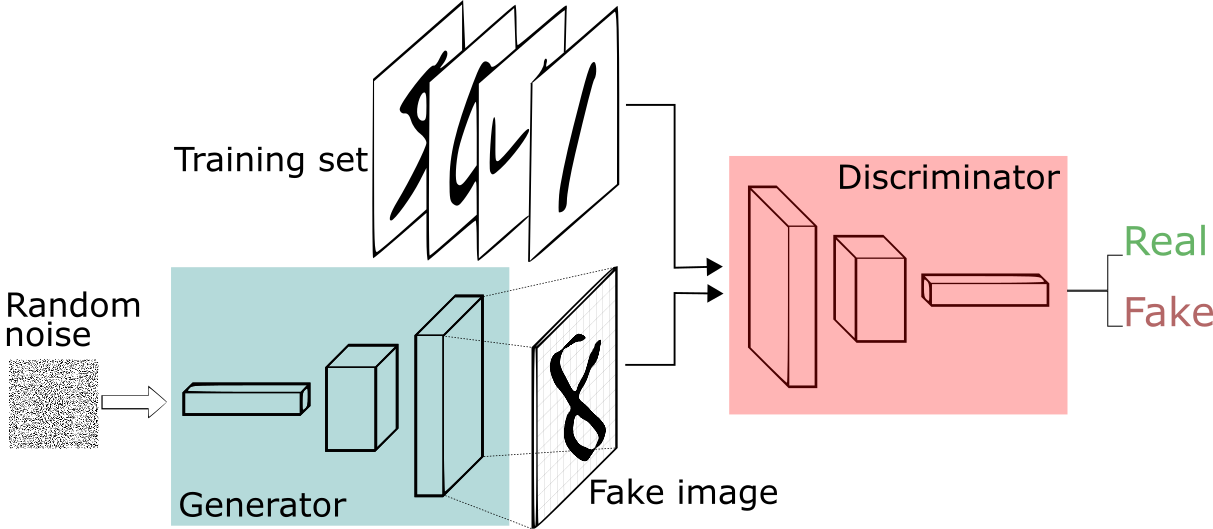

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2
# image input size
image_size=28

# Setting up transforms to resize and normalize 
transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )),
                               ])
# batchsize of dataset
batch_size = 100

# Load MNIST Dataset
gan_train_dataset = datasets.MNIST(root='./MNIST/', train=True, transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw



In [2]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        self.main = (
            nn.Sequential(
              nn.ConvTranspose2d(100, 256, 7, 1, 0, bias=False),
              nn.BatchNorm2d(256),
              nn.ReLU(),
              
              nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
              nn.BatchNorm2d(128),
              nn.ReLU(),

              nn.ConvTranspose2d(128, 64, 3, 1, 1, bias=False),
              nn.BatchNorm2d(64),
              nn.ReLU(),
            
              nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
              nn.Tanh() #We need to use tanh to return the data to the input data range or [-1,1]
            )
        ) 

    def forward(self, input):
        out = self.main(input)
        return out

class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128,1,7,1,0),  
            nn.Sigmoid() #We need to use Sigmoid here in the last layer to return the data to the range of [0,1] as a binary classifier
        )
    def forward(self, input):
        out = self.main(input) 
        return out.view(-1,1)

g=DCGAN_Generator()
batchsize=2
z=torch.zeros((batchsize, 100, 1, 1))
#out = g(z)


d=DCGAN_Discriminator()
x=torch.zeros((batchsize, 1, 28, 28))
#out = d(x)


GAN loss

In [3]:
import torch

def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):
    output = D.forward(real.detach()).view(-1)
    loss_D = criterion(output, Valid_label)
    loss_D.backward()
    fake_imgs = G.forward(noise)
    output = D.forward(fake_imgs.detach()).view(-1)
    loss_fake = criterion(output, Fake_label)
    loss_fake.backward()
    loss_D = loss_D + loss_fake
    optimizerD.step()

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    output = netD.forward(fake).view(-1)
    loss_G = criterion(output, Valid_label)
    loss_G.backward()
    optimizerG.step()

    
    return loss_G

In [4]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

from torchsummary import summary
print(summary(netG,(100,1,1)))
print(summary(netD,(1, 28, 28)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 7, 7]       1,254,400
       BatchNorm2d-2            [-1, 256, 7, 7]             512
              ReLU-3            [-1, 256, 7, 7]               0
   ConvTranspose2d-4          [-1, 128, 14, 14]         524,288
       BatchNorm2d-5          [-1, 128, 14, 14]             256
              ReLU-6          [-1, 128, 14, 14]               0
   ConvTranspose2d-7           [-1, 64, 14, 14]          73,728
       BatchNorm2d-8           [-1, 64, 14, 14]             128
              ReLU-9           [-1, 64, 14, 14]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,024
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 1,854,336
Trainable params: 1,854,336
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

TRAINING

[0/25][0/600]	Loss_D: 1.3141	Loss_G: 1.1470	
[0/25][50/600]	Loss_D: 0.0591	Loss_G: 3.8378	
[0/25][100/600]	Loss_D: 0.0139	Loss_G: 4.9129	
[0/25][150/600]	Loss_D: 0.0231	Loss_G: 4.8986	
[0/25][200/600]	Loss_D: 0.0696	Loss_G: 4.2780	
[0/25][250/600]	Loss_D: 0.7776	Loss_G: 1.7417	
[0/25][300/600]	Loss_D: 1.1537	Loss_G: 0.9367	
[0/25][350/600]	Loss_D: 1.0731	Loss_G: 0.8423	
[0/25][400/600]	Loss_D: 0.9406	Loss_G: 1.0036	
[0/25][450/600]	Loss_D: 1.1808	Loss_G: 1.9881	
[0/25][500/600]	Loss_D: 0.8749	Loss_G: 1.3811	
[0/25][550/600]	Loss_D: 0.9407	Loss_G: 1.7066	
[1/25][0/600]	Loss_D: 0.8843	Loss_G: 1.0567	
[1/25][50/600]	Loss_D: 0.8759	Loss_G: 1.4306	
[1/25][100/600]	Loss_D: 1.3715	Loss_G: 0.3871	
[1/25][150/600]	Loss_D: 0.9051	Loss_G: 1.6694	
[1/25][200/600]	Loss_D: 1.0442	Loss_G: 0.6557	
[1/25][250/600]	Loss_D: 1.1515	Loss_G: 2.1248	
[1/25][300/600]	Loss_D: 0.8787	Loss_G: 1.2984	
[1/25][350/600]	Loss_D: 1.0819	Loss_G: 2.0451	
[1/25][400/600]	Loss_D: 0.9241	Loss_G: 1.9727	
[1/25][450/600]	Los

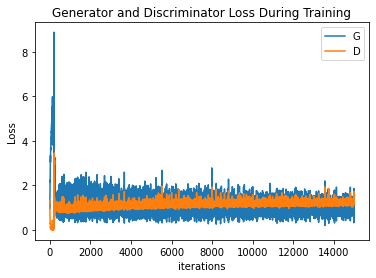

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of channels
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100

# Create the generator and discriminator
netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)

# Initialize BCELoss function
criterion = nn.BCELoss()

# Create latent vector to test the generator performance
fixed_noise = torch.randn(36, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D

optimizerD =  optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG =  optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 25

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

        netD.zero_grad()
        loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
        netG.zero_grad()
        loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))

        # Save Losses for plotting later
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))




## Qualitative Visualisations

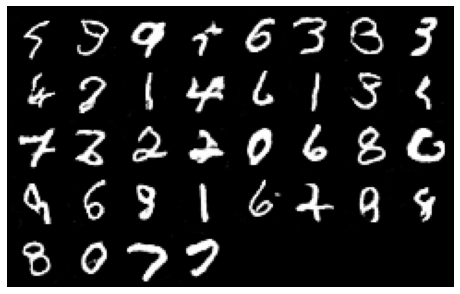

In [ ]:
# Test GAN on a random sample and display on 6X6 grid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Sources**

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html 

Advanced Computer Vision (Columbia University, Carl Vondrick)